In [1]:
# Алексеев Д.П. (DSU-4,ZAK-8)
# Домашнее задание к лекции «Методология ведения DS-проектов» (#2).

# Задание:
# Возьмите задачу с винами (https://www.kaggle.com/datasets/rajyellow46/wine-quality) 
# и решите ее, оформив в виде CrispDM-подхода. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# загрузим датасет
data = pd.read_csv('E:\\Netology\\Работа с заказчиком\\Practice\\winequalityN.csv')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Этап 1. Business Understanding.

Для понимания задачи и описания предметной области возьмем описание датасета из Kaggle:

"Данные были загружены из репозитория машинного обучения UCI.

Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde». 
Из соображений конфиденциальности доступны только физико-химические (входные) и 
органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т.д.)

Эти наборы данных можно рассматривать как задачи классификации или регрессии. 
Классы упорядочены и не сбалансированы (например, нормальных вин гораздо больше, чем отличных или плохих). 
Алгоритмы обнаружения выбросов можно использовать для определения нескольких отличных или плохих вин."

Из описания датасета и перечня полей можно сделать вывод, что в задаче необходимо предсказать целевую переменную - качество вина в баллах(quality).

Этап 2. Data Understanding.

In [4]:
# Выведем общую статистику
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
data['type'].value_counts()

white    4898
red      1599
Name: type, dtype: int64

Видно, что в датасете одна категорийная переменная - тип вина 'type' (белое/красное). 
Её значения потом можно закодировать через one-hot-encoding.

Есть пропуски в некоторых признаках, выведем их список.
Эти пропуски потом можно либо просто удалить, либо заполнить 
(переменные - непрерывные, поэтому можно заполнить средними значениями).

In [7]:
columns_with_NA = data.columns[data.isnull().any()].tolist()
pd.isnull(data[columns_with_NA]).sum().sort_values(ascending=False)

fixed acidity       10
pH                   9
volatile acidity     8
sulphates            4
citric acid          3
residual sugar       2
chlorides            2
dtype: int64

Построим тепловую карту взаимной корреляции всех признаков (включая целевую переменную quality).

<AxesSubplot:>

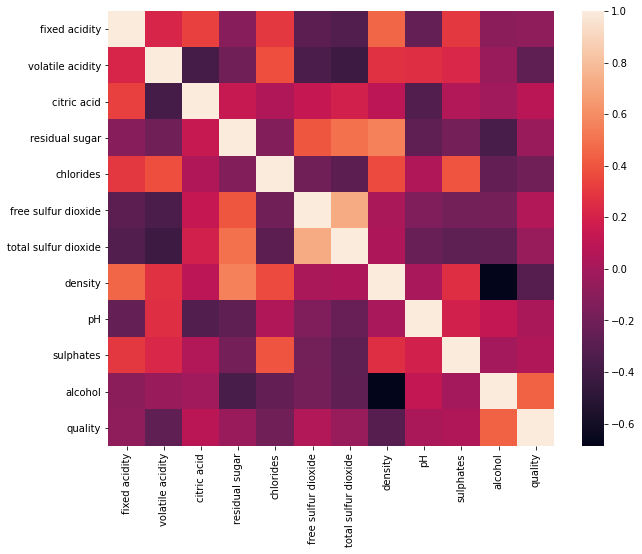

In [8]:
plt.figure(figsize = (10, 8))
sns.heatmap(data.corr())

Самая выраженная корреляция с целевой переменной - у признака 'alcohol'.
Сильно выраженная взаимная корреляция - у признаков 'free sulfur dioxide' и 'total sulfur dioxide', что логично.
Тем не менее, попробуем не удалять никакие признаки и посмотреть, что получится с качеством предсказаний.

Теперь посмотрим, есть ли выбросы. Для визуальной оценки выбросов воспользуемся боксплот-диаграммами по каждому из входящих признаков, кроме категориальной переменной type.

<Figure size 1440x360 with 0 Axes>

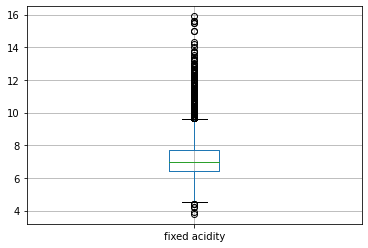

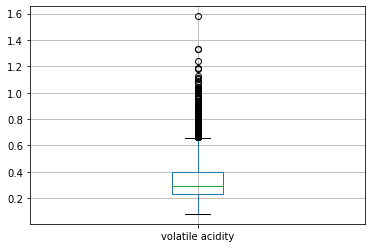

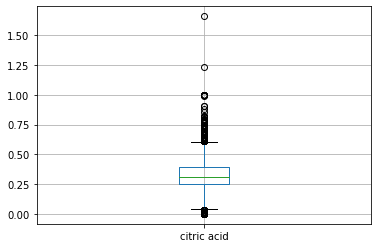

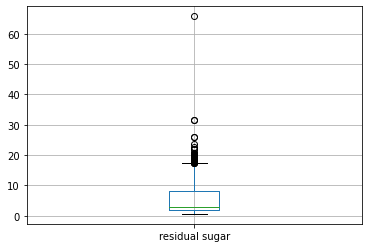

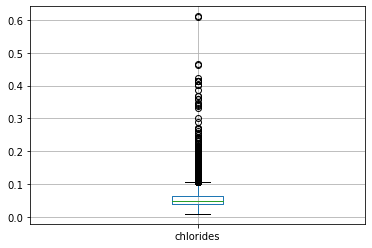

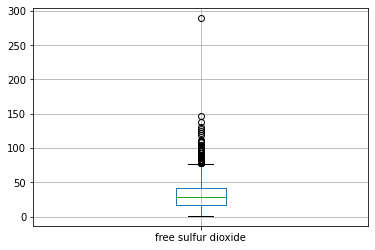

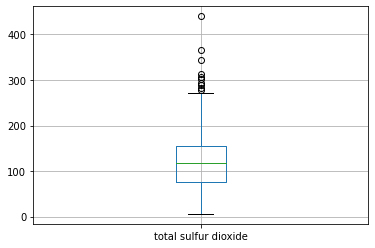

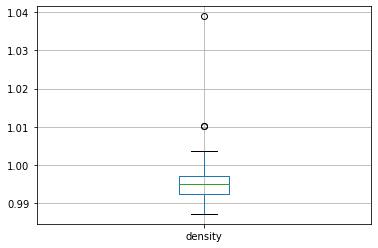

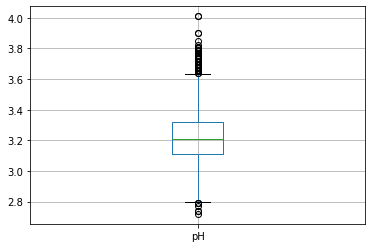

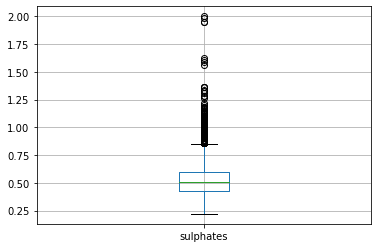

In [9]:
to_outliers = data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                            'free sulfur dioxide', 'total sulfur dioxide', 'density',
                            'pH', 'sulphates']]

plt.figure(figsize = (20,5))
for i in to_outliers:
    data[[i]].plot(kind = 'box', grid = True)

In [10]:
# Дополнительно для оценки списка возможных выбросов выведем по каждому признаку 
# подсчет уникальных значений с сортировкой по возрастанию,
# что также позволит увидеть "единичные" и нетипичные отклонения.
for i in to_outliers:
    print(data[i].value_counts(ascending=True).to_frame())

       fixed acidity
6.45               1
3.90               1
14.30              1
13.50              1
12.10              1
...              ...
6.90             279
7.00             282
6.40             305
6.60             326
6.80             354

[106 rows x 1 columns]
       volatile acidity
1.025                 1
0.135                 1
0.930                 1
0.825                 1
0.355                 1
...                 ...
0.220               235
0.250               238
0.260               255
0.240               265
0.280               286

[187 rows x 1 columns]
      citric acid
0.86            1
0.88            1
1.23            1
0.75            1
0.99            1
...           ...
0.26          257
0.49          283
0.32          289
0.28          301
0.30          337

[89 rows x 1 columns]
       residual sugar
2.55                1
3.15                1
9.05                1
7.95                1
11.45               1
...               ...
1.20              1

По боксплотам, описанию данных (data.describe) и выводу списка отсортированных значений можно предположить, 
что есть выбросы в признаках:
        1) residual sugar (значения>40);
        2) free sulfur dioxide (значения>200);
        3) total sulfur dioxide (значения>400).
    
На следующем этапе удалим эти выбросы, затем сделаем OHE для переменной 'type' и заполним пропуски средним значением.

Также, учитывая, что многие входящие признаки разного масштаба, то неплохо было сделать их стандартизацию StandardScaler'ом перед обучением.

Этап 3. Data Preparation.

In [11]:
data_corrected = data.loc[data['residual sugar'] < 40]
data_corrected = data_corrected.loc[data_corrected['free sulfur dioxide'] < 200]
data_corrected = data_corrected.loc[data_corrected['total sulfur dioxide'] < 400]
data_corrected.reindex()
data_corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6493 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6493 non-null   object 
 1   fixed acidity         6483 non-null   float64
 2   volatile acidity      6485 non-null   float64
 3   citric acid           6490 non-null   float64
 4   residual sugar        6493 non-null   float64
 5   chlorides             6491 non-null   float64
 6   free sulfur dioxide   6493 non-null   float64
 7   total sulfur dioxide  6493 non-null   float64
 8   density               6493 non-null   float64
 9   pH                    6484 non-null   float64
 10  sulphates             6489 non-null   float64
 11  alcohol               6493 non-null   float64
 12  quality               6493 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 710.2+ KB


In [12]:
# Для заполнения пропусков воспользуемся классом SimpleImputer библиотеки scikit-learn
from sklearn.impute import SimpleImputer

# возьмем только те признаки, в которых есть пропуски
fillna_mean = ['fixed acidity', 'pH', 'volatile acidity', 'sulphates', 
                         'citric acid', 'residual sugar', 'chlorides']

for i in fillna_mean:
    imp = SimpleImputer(missing_values = np.nan, strategy='mean') # будем заполнять пропуски средним значением по колонке
    data_corrected[i] = imp.fit_transform(data_corrected[[i]])[:, 0]  # тренируем и заполняем
    
data_corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6493 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6493 non-null   object 
 1   fixed acidity         6493 non-null   float64
 2   volatile acidity      6493 non-null   float64
 3   citric acid           6493 non-null   float64
 4   residual sugar        6493 non-null   float64
 5   chlorides             6493 non-null   float64
 6   free sulfur dioxide   6493 non-null   float64
 7   total sulfur dioxide  6493 non-null   float64
 8   density               6493 non-null   float64
 9   pH                    6493 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6493 non-null   float64
 12  quality               6493 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 710.2+ KB


In [13]:
# сделаем one-hot-encoding для переменной type
data_corrected = pd.get_dummies(data_corrected, columns=['type'])

In [14]:
# проверка корректности OHE
data_corrected['type_red'].value_counts()

0    4894
1    1599
Name: type_red, dtype: int64

In [15]:
data_corrected.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,7.216790,0.339669,0.318683,5.435423,0.056044,30.480440,115.672493,0.994690,3.218310,0.531165,10.491934,5.818574,0.246265,0.753735
std,1.295993,0.164374,0.145231,4.699418,0.035040,17.451524,56.379949,0.002949,0.160629,0.148791,1.192819,0.872695,0.430868,0.430868
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.660000,31.600000,0.611000,146.500000,366.500000,1.010300,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000


In [17]:
from sklearn.preprocessing import StandardScaler

# зададим список признаков, подлежащих стандартизации. Целевую переменную не трогаем))
cols_to_norm = data_corrected[['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 
                               'pH', 'alcohol']]

In [18]:
# создадим и обучим скейлер
scaler = StandardScaler()
data_corrected[['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 
                'pH', 'alcohol']] = scaler.fit_transform(cols_to_norm)

In [20]:
data_corrected.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
count,6.493000e+03,6493.000000,6493.000000,6.493000e+03,6493.000000,6.493000e+03,6.493000e+03,6493.000000,6.493000e+03,6493.000000,6.493000e+03,6493.000000,6493.000000,6493.000000
mean,2.049629e-15,0.339669,0.318683,-1.325274e-15,0.056044,2.028769e-16,-2.184641e-15,0.994690,-1.281211e-15,0.531165,1.880950e-16,5.818574,0.246265,0.753735
std,1.000077e+00,0.164374,0.145231,1.000077e+00,0.035040,1.000077e+00,1.000077e+00,0.002949,1.000077e+00,0.148791,1.000077e+00,0.872695,0.430868,0.430868
min,-2.636630e+00,0.080000,0.000000,-1.029020e+00,0.009000,-1.689406e+00,-1.945389e+00,0.987110,-3.102488e+00,0.220000,-2.089275e+00,3.000000,0.000000,0.000000
25%,-6.302913e-01,0.230000,0.250000,-7.736496e-01,0.038000,-7.725101e-01,-6.859792e-01,0.992340,-6.743387e-01,0.430000,-8.316527e-01,5.000000,0.000000,1.000000
50%,-1.672901e-01,0.290000,0.310000,-5.182792e-01,0.047000,-8.483812e-02,4.128570e-02,0.994890,-5.173630e-02,0.510000,-1.609207e-01,6.000000,0.000000,1.000000
75%,3.728780e-01,0.400000,0.390000,5.670452e-01,0.065000,6.028339e-01,7.153361e-01,0.996990,6.331263e-01,0.600000,6.774943e-01,6.000000,0.000000,1.000000
max,6.700561e+00,1.580000,1.660000,5.568050e+00,0.611000,6.648617e+00,4.449220e+00,1.010300,4.929083e+00,2.000000,3.695788e+00,9.000000,1.000000,1.000000


Теперь всё готово для следующего этапа - непосредственно моделирования и обучения.

Этап 4. Modeling.

In [21]:
# загрузим библиотеку для разделения выборки на трейн и тест
from sklearn.model_selection import train_test_split

In [22]:
X = data_corrected[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                    'free sulfur dioxide', 'total sulfur dioxide', 'density',
                    'pH', 'sulphates', 'alcohol', 'type_red', 'type_white']]

y = data_corrected['quality']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Для решения задачи классификации используем модель логистической регрессии
from sklearn.linear_model import LogisticRegression

In [36]:
# создаем модель
model = LogisticRegression(max_iter=500)

In [37]:
# обучаем на трейн-выборке
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [38]:
# оценим качество на трейн-выборке
model.score(X_train, y_train)

0.5507150715071507

In [39]:
# оценим качество на тест-выборке
model.score(X_test, y_test)

0.5400410677618069

Как видим, с использованием логистической регрессии качество предсказаний получилось невысоким.
Попробуем использовать другую модель. Полагаю, должна хорошо подойти модель дерева решений.
Используем DecisionTreeClassifier, а не DecisionTreeRegressor, т.к. целевая переменная является дискретной.

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
np.random.seed(42) #зафиксируем seed для повторяемости результатов

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
model_tree.score(X_train, y_train)

1.0

Качество на трейн-выборке предсказуемо идеальное.

In [43]:
model_tree.score(X_test, y_test)

0.5913757700205339

Качество на тест-выборке выше, чем с использованием логистической регрессии, но всё равно невысокое.
Попробуем "случайный лес".

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
np.random.seed(42) #зафиксируем seed для повторяемости результатов

model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)

RandomForestClassifier()

In [49]:
model_RF.score(X_test, y_test)

0.6673511293634496

C RandomForest качество предсказаний заметно улучшилось.
Напоследок попробуем ExtraTreesClassifier

In [50]:
from sklearn.ensemble import ExtraTreesClassifier

In [51]:
np.random.seed(42) #зафиксируем seed для повторяемости результатов

model_ET = ExtraTreesClassifier()
model_ET.fit(X_train, y_train)

ExtraTreesClassifier()

In [52]:
model_ET.score(X_test, y_test)

0.6745379876796714

Качество ещё незначительно улучшилось, но в пределах погрешности. 

Этапы 5 и 6. Оценка решения и внедрение.

Полагаю, что можно остановиться на достигнутом результате: использовать модель ExtraTreesClassifier 
(коэфф-т детерминации на тестовой выборке равен 0.6745379876796714).

Вывод: путем подбора модели (обычным способом, без использования продвинутых алгоритмов перебора моделей/признаков) 
удалось добиться существенного прироста качества предсказаний - от 0.54 на простой логистической регресии 
до 0.67 на ExtraTreesClassifier.

Также можно сделать вывод, что в повышении точности предсказаний огромную роль играет качественная предобработка данных.